# Autoencoder for getting vector embeddings

**Advisor:** Marcos M. Raimundo <br>
**Co-Advisor:** Thalita Veronese <br>
**Student:** João Victor P. B. Avanzini

## Imports

In [1]:
import tensorflow as tf
import os

import neurokit2 as nk


import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.keras import TqdmCallback

from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, Flatten, Input, Conv1DTranspose, Conv2DTranspose, Reshape
from tensorflow.keras.optimizers import Adam
from keras.utils import to_categorical
import tensorflow as tf

from matplotlib.offsetbox import OffsetImage, AnnotationBbox

sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

2023-12-06 17:47:19.223651: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-06 17:47:19.223688: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-06 17:47:19.225010: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-06 17:47:19.231999: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-06 17:47:20.203981: W tensorflow/compiler/tf2

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA GeForce GTX TITAN X, pci bus id: 0000:04:00.0, compute capability: 5.2
/job:localhost/replica:0/task:0/device:GPU:1 -> device: 1, name: NVIDIA GeForce GTX TITAN X, pci bus id: 0000:05:00.0, compute capability: 5.2



2023-12-06 17:47:22.372917: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11602 MB memory:  -> device: 0, name: NVIDIA GeForce GTX TITAN X, pci bus id: 0000:04:00.0, compute capability: 5.2
2023-12-06 17:47:22.373483: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 11601 MB memory:  -> device: 1, name: NVIDIA GeForce GTX TITAN X, pci bus id: 0000:05:00.0, compute capability: 5.2


## 30 Subjects of single ECG autoencoder

In [2]:
subjects = pd.read_csv('../data/merged_ecg_data.csv')
subjects = subjects[:39000000]

In [3]:
subjects.shape

(39000000, 1)

In [4]:
subjects_reshaped = subjects.values.reshape((1300, 30000, 1))
subjects_reshaped.shape

(1300, 30000, 1)

## 30 Subjects ECG autoencoder

In [5]:
encoder = tf.keras.models.Sequential([
    Conv1D(64, 1300, activation='relu', padding='same', input_shape=(30000, 1)),
    Dense(32, activation='relu'),
    MaxPooling1D(),
    Conv1D(32, 1300, activation='relu', padding='same'),
    Dense(16, activation='relu'),
    MaxPooling1D(),
    Flatten(),
    Dense(8)
    
], name='encoder')

2023-12-06 17:47:27.019583: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11602 MB memory:  -> device: 0, name: NVIDIA GeForce GTX TITAN X, pci bus id: 0000:04:00.0, compute capability: 5.2
2023-12-06 17:47:27.019796: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 11601 MB memory:  -> device: 1, name: NVIDIA GeForce GTX TITAN X, pci bus id: 0000:05:00.0, compute capability: 5.2


In [6]:
encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 30000, 64)         83264     
                                                                 
 dense (Dense)               (None, 30000, 32)         2080      
                                                                 
 max_pooling1d (MaxPooling1  (None, 15000, 32)         0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 15000, 32)         1331232   
                                                                 
 dense_1 (Dense)             (None, 15000, 16)         528       
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 7500, 16)          0         
 g1D)                                                      

In [7]:
decoder = tf.keras.models.Sequential([
    Reshape((8, 1)),
    Conv1DTranspose(8, 29993, activation='relu', input_shape=(8, 1)),
    Dense(16, activation='relu'),
    Conv1DTranspose(16, 1300, activation='relu', padding='same'),
    Dense(32, activation='relu'),
    Conv1DTranspose(32, 1300, activation='relu', padding='same'),
    Dense(64, activation='relu'),
    Conv1DTranspose(1, 1300, activation='relu', padding='same'),
], name='decoder')

In [8]:
#decoder.summary()

In [9]:
autoencoder = Sequential([encoder, decoder])
autoencoder.summary(expand_nested=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Sequential)        (None, 8)                 2377112   
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| conv1d (Conv1D)            (None, 30000, 64)         83264    |
|                                                               |
| dense (Dense)              (None, 30000, 32)         2080     |
|                                                               |
| max_pooling1d (MaxPooling  (None, 15000, 32)         0        |
| 1D)                                                           |
|                                                               |
| conv1d_1 (Conv1D)          (None, 15000, 32)         1331232  |
|                                                               |
| dense_1 (Dense)            (None, 15000, 16)         528      |
|                                                       

In [ ]:
autoencoder.compile(optimizer = "adam", loss = "mse")
history = autoencoder.fit(subjects_reshaped, subjects_reshaped, batch_size = 128, epochs = 100, verbose = 0, callbacks=[TqdmCallback(verbose=1)])

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

2023-12-06 17:47:30.254977: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2023-12-06 17:49:41.331948: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f3b19410200 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-06 17:49:41.331975: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX TITAN X, Compute Capability 5.2
2023-12-06 17:49:41.331981: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA GeForce GTX TITAN X, Compute Capability 5.2
2023-12-06 17:49:41.337505: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1701884981.440671    4220 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


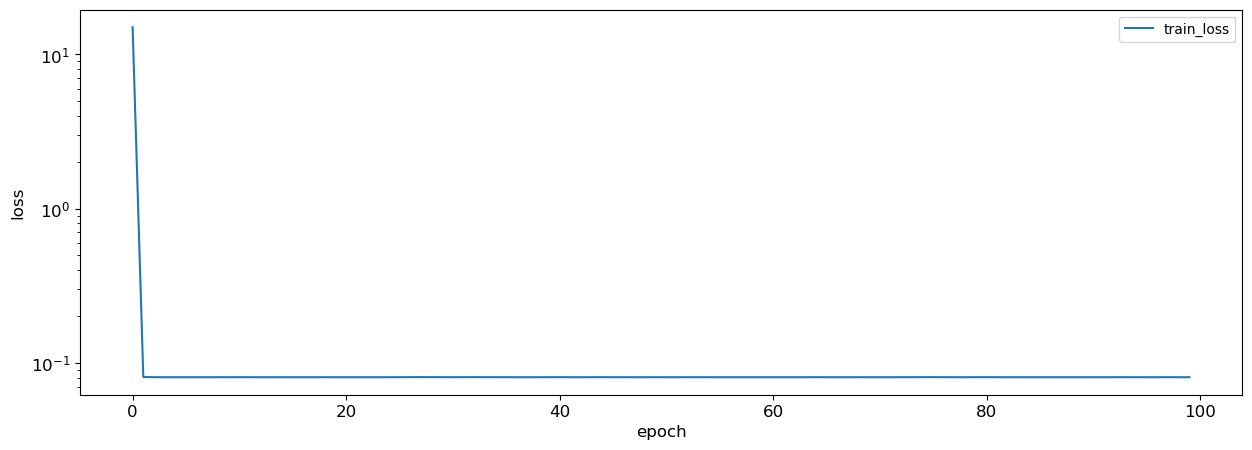

In [18]:
plot_df = pd.DataFrame.from_dict({'train_loss':history.history['loss']})
plot_df.plot(logy=True, figsize=(15,5), fontsize=12)
plt.xlabel('epoch', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.show()

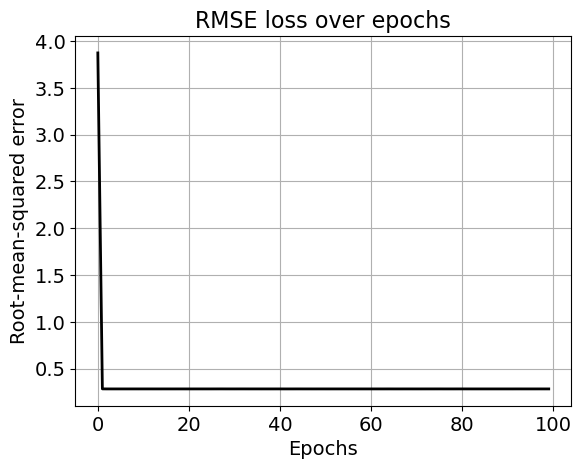

In [19]:
plt.title("RMSE loss over epochs",fontsize=16)
plt.plot(np.sqrt(history.history['loss']), label='Training RMSE', c='k', lw=2)
plt.grid(True)
plt.xlabel("Epochs",fontsize=14)
plt.ylabel("Root-mean-squared error",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [20]:
print("Epoch\tRMSE")
for epoch, rmse in enumerate(np.sqrt(history.history['loss'])):
    print(f"{epoch}\t{rmse}")

Epoch	RMSE
0	3.8734131301784185
1	0.2842197586595317
2	0.2838522345217586
3	0.28380944690099635
4	0.2838062703848261
5	0.2837918312268491
6	0.283784887042902
7	0.2837807650839732
8	0.28384369063804615
9	0.2838140540988747
10	0.2838472079669392
11	0.28383372901111276
12	0.28380528592011856
13	0.28378950776644785
14	0.28378942900474496
15	0.2838253289485837
16	0.2837891270846814
17	0.28381129766468716
18	0.28383166839378593
19	0.2838088562291928
20	0.28378585845125687
21	0.28379528356508216
22	0.28382417392054404
23	0.2837859240868366
24	0.2838280589961745
25	0.2838464205090334
26	0.28392507676478485
27	0.2840247764340738
28	0.2839320962422324
29	0.28389435958946346
30	0.2838472735883327
31	0.28390055315330637
32	0.2839740389237662
33	0.2838882446248055
34	0.28387350780610554
35	0.2838669199513804
36	0.2837796755115765
37	0.28381658736954435
38	0.28381263650749333
39	0.2838596757593334
40	0.28390464712980584
41	0.283811245160919
42	0.28379248756814945
43	0.28384731296116156
44	0.28390466

## Inference process

In [21]:
def process_subject(ax, subject_number):
    file_path = f'../data/output_blobs_case_{subject_number}_merged.csv'
    
    subject_data = pd.read_csv(file_path)
    
    subject_data = subject_data[:300000]
    
    subject_data = subject_data.values.reshape((10, 30000, 1))
    
    encoder_embeddings = encoder.predict(subject_data)
    
    ax.plot(encoder_embeddings)
    ax.set_title(f'Subject {subject_number}')
    
    return encoder_embeddings.flatten()

1/1 [==============================] - 0s 165ms/step


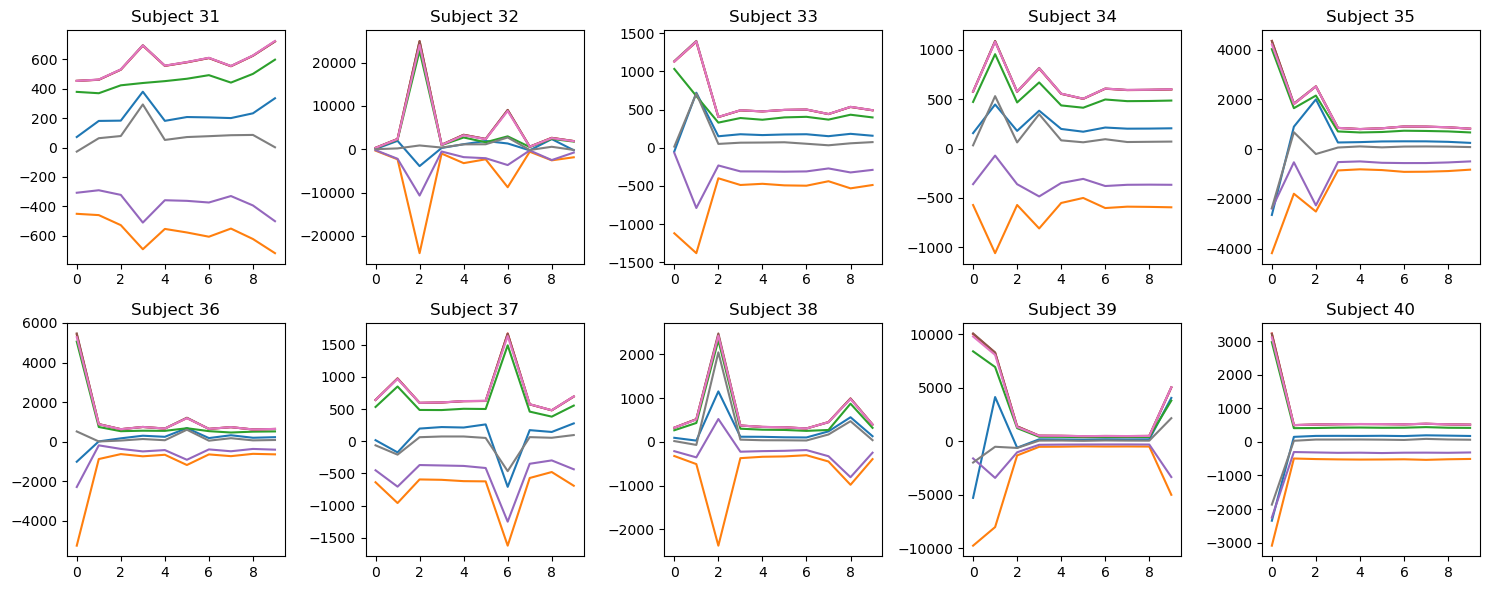

In [22]:
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

embeddings_list = []
for ax, subject_number in zip(axes.flatten(), range(31, 42)):
    embeddings = process_subject(ax, subject_number)
    embeddings_list.append(embeddings)

plt.tight_layout()
plt.show()

In [23]:
embeddings_df = pd.DataFrame(embeddings_list)
embeddings_df.to_csv('encoder_embeddings.csv', index=False)

In [24]:
embeddings_df

,0,1,2,3,4,5,6,7,8,9,...,70,71,72,73,74,75,76,77,78,79
0,71.772980,-450.417145,378.868256,453.777100,-307.182800,453.675385,453.598511,-27.245577,181.286438,-459.280426,...,626.532349,86.036453,335.423828,-718.054810,597.880676,721.741516,-500.642242,722.193176,725.212646,2.107117
1,65.180382,-320.350342,267.754395,322.196930,-209.525742,322.875397,323.024536,6.148699,1933.905640,-2322.805176,...,2572.347900,567.642822,-231.903641,-1854.798584,1765.284058,1878.432739,-766.396667,1887.338989,1862.680908,-159.305023
2,-48.357361,-1120.640747,1032.444824,1128.238037,-67.048828,1134.733643,1128.969116,14.895543,720.884277,-1381.359497,...,536.179016,58.134457,157.250717,-488.360352,397.188995,490.654724,-290.065948,491.300323,491.980682,73.775002
3,155.373291,-571.383972,470.693268,574.230896,-360.245758,575.122314,575.620422,31.983633,444.625458,-1057.773193,...,594.530334,67.843231,204.203400,-594.177063,484.605408,596.497681,-366.760345,597.788208,598.657654,69.943634
4,-2642.519775,-4178.876953,4024.352295,4354.256348,-2387.385742,4350.368164,4211.689453,-2362.656494,906.449890,-1789.598267,...,884.573181,105.165527,256.036438,-821.408691,675.481079,824.797607,-489.450104,826.572998,827.741638,87.138763
5,-1012.402649,-5252.604004,5054.680664,5416.783691,-2289.483398,5467.818359,5281.065430,516.415466,14.339768,-877.125488,...,618.452637,66.222008,227.686203,-640.035034,518.692139,642.624023,-402.865906,643.764832,644.819458,85.246712
6,16.728300,-636.764709,532.543274,641.980835,-450.711273,641.554932,641.618713,-63.263397,-173.131882,-959.491882,...,481.678680,54.146225,277.431610,-691.172668,554.127197,693.596130,-435.525391,695.191345,696.402283,96.262329
7,93.047295,-322.929413,265.786438,324.330811,-212.342468,324.981903,325.175201,18.511131,29.252384,-507.757294,...,979.897400,472.688782,129.663940,-393.954895,320.780426,395.594482,-247.254028,396.410156,396.945618,39.333103
8,-5298.762207,-9773.545898,8418.635742,10036.958984,-1605.286255,10094.237305,9808.301758,-1992.720337,4139.765137,-8034.864258,...,499.331970,56.368149,4057.283936,-5012.545898,3804.538330,5028.709473,-3349.004883,5051.396973,5056.181641,2161.664062
9,-2348.781494,-3092.040527,2970.298828,3229.061523,-2253.867432,3211.524414,3110.372803,-1869.760132,149.026611,-495.961670,...,522.627075,70.719017,175.186661,-509.224731,416.381561,511.181580,-315.637451,512.436462,513.030701,63.153957
